In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'


In [3]:
import os
import shutil
import random

original_dir = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
base_output = '/content/covid_dataset'

# Split ratio
split_ratio = 0.8  # 80% training, 20% validation

# Create train and val folders for each class
for split in ['train', 'val']:
    for cls in os.listdir(original_dir):
        cls_path = os.path.join(original_dir, cls)
        if os.path.isdir(cls_path):  # ✅ Check if it's a folder
            os.makedirs(os.path.join(base_output, split, cls), exist_ok=True)

# Copy images to train and val
for cls in os.listdir(original_dir):
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):  # ✅ Skip files like .xlsx
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        split_index = int(len(images) * split_ratio)

        train_images = images[:split_index]
        val_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(base_output, 'train', cls, img))
        for img in val_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(base_output, 'val', cls, img))


In [4]:
original_dir = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
base_output = '/content/covid_dataset'
split_ratio = 0.8  # 80% train, 20% val

for split in ['train', 'val']:
    for cls in os.listdir(original_dir):
        cls_path = os.path.join(original_dir, cls, 'images')  # 👈 go into 'images'
        if os.path.isdir(cls_path):
            os.makedirs(os.path.join(base_output, split, cls), exist_ok=True)

# Copy images
for cls in os.listdir(original_dir):
    cls_path = os.path.join(original_dir, cls, 'images')  # 👈 go into 'images'
    if os.path.isdir(cls_path):
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"{cls}: {len(images)} images found")

        random.shuffle(images)
        split_index = int(len(images) * split_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(base_output, 'train', cls, img))
        for img in val_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(base_output, 'val', cls, img))


Normal: 10204 images found
Lung_Opacity: 6012 images found
Viral Pneumonia: 1345 images found
COVID: 3616 images found


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    '/content/covid_dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    '/content/covid_dataset/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 16940 images belonging to 4 classes.
Found 4237 images belonging to 4 classes.


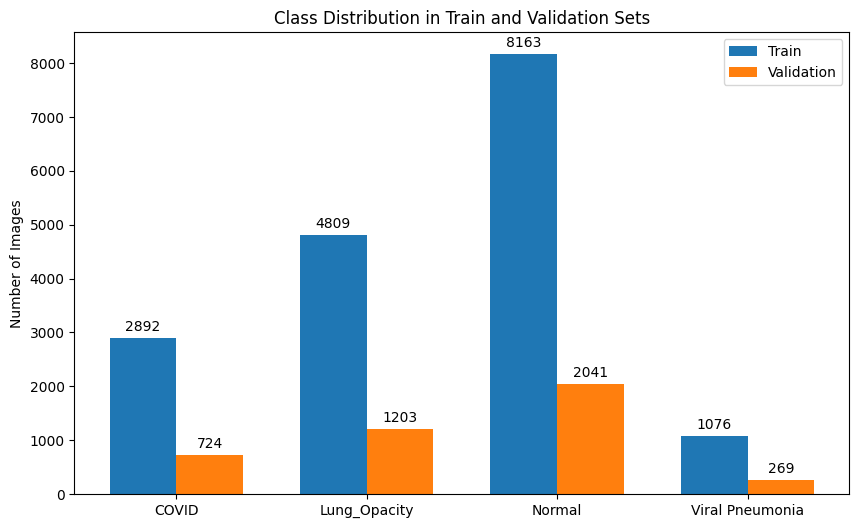

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get class indices and their names
class_indices = train_data.class_indices
class_names = list(class_indices.keys())

# Count number of images per class in train and val
train_counts = []
val_counts = []

# train_data.samples gives total number of images in train_data
# but we want counts per class — use train_data.classes which has class labels for all images
for i in range(len(class_names)):
    train_counts.append(np.sum(train_data.classes == i))
    val_counts.append(np.sum(val_data.classes == i))

# Plotting the distribution
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution in Train and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Add text labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_data.classes is your label array
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)


{0: np.float64(1.464384508990318), 1: np.float64(0.8806404657933042), 2: np.float64(0.5188043611417371), 3: np.float64(3.9358736059479553)}


In [9]:

import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
history = model.fit(
    train_data,
    epochs=10,              # or however many epochs you want
    validation_data=val_data,
    class_weight=class_weights_dict
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - accuracy: 0.7165 - loss: 0.6244 - val_accuracy: 0.8154 - val_loss: 0.4723
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - accuracy: 0.8329 - loss: 0.3692 - val_accuracy: 0.8551 - val_loss: 0.3878
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - accuracy: 0.8583 - loss: 0.3019 - val_accuracy: 0.8515 - val_loss: 0.3961
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 71s 134ms/step - accuracy: 0.8690 - loss: 0.2795 - val_accuracy: 0.8690 - val_loss: 0.3479
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 72s 136ms/step - accuracy: 0.8837 - loss: 0.2421 - val_accuracy: 0.8815 - val_loss: 0.3169
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.8888 - loss: 0.2310 - val_accuracy: 0.8638 - val_loss: 0.3550
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 65s 122ms/step - accuracy: 0.8912 - loss: 0.2230 - val_accuracy: 0.8806 - val_loss: 0.3126
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.8978 - loss: 0.2080 - val

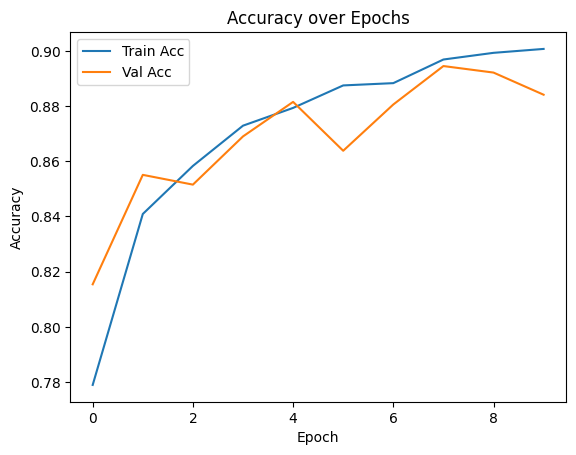

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels
class_names = list(train_data.class_indices.keys())

# Disable shuffle to preserve label order
train_data.shuffle = False
val_data.shuffle = False

# 🔹 Predict on Training Data
train_preds = model.predict(train_data, verbose=1)
train_pred_classes = np.argmax(train_preds, axis=1)
true_train_labels = train_data.classes

train_acc = accuracy_score(true_train_labels, train_pred_classes)
print("✅ Train Accuracy:", train_acc)
print("📄 Train Classification Report:\n", classification_report(true_train_labels, train_pred_classes, target_names=class_names))

# 🔹 Predict on Validation Data
val_preds = model.predict(val_data, verbose=1)
val_pred_classes = np.argmax(val_preds, axis=1)
true_val_labels = val_data.classes

val_acc = accuracy_score(true_val_labels, val_pred_classes)
print("✅ Validation Accuracy:", val_acc)
print("📄 Validation Classification Report:\n", classification_report(true_val_labels, val_pred_classes, target_names=class_names))


530/530 ━━━━━━━━━━━━━━━━━━━━ 54s 102ms/step
✅ Train Accuracy: 0.9256788665879575
📄 Train Classification Report:
                  precision    recall  f1-score   support

          COVID       0.95      0.96      0.96      2892
   Lung_Opacity       0.88      0.92      0.90      4809
         Normal       0.95      0.91      0.93      8163
Viral Pneumonia       0.87      1.00      0.93      1076

       accuracy                           0.93     16940
      macro avg       0.91      0.95      0.93     16940
   weighted avg       0.93      0.93      0.93     16940

133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step
✅ Validation Accuracy: 0.8841161198961529
📄 Validation Classification Report:
                  precision    recall  f1-score   support

          COVID       0.91      0.86      0.88       724
   Lung_Opacity       0.83      0.89      0.86      1203
         Normal       0.92      0.87      0.90      2041
Viral Pneumonia       0.84      0.99      0.91       269

       accuracy    

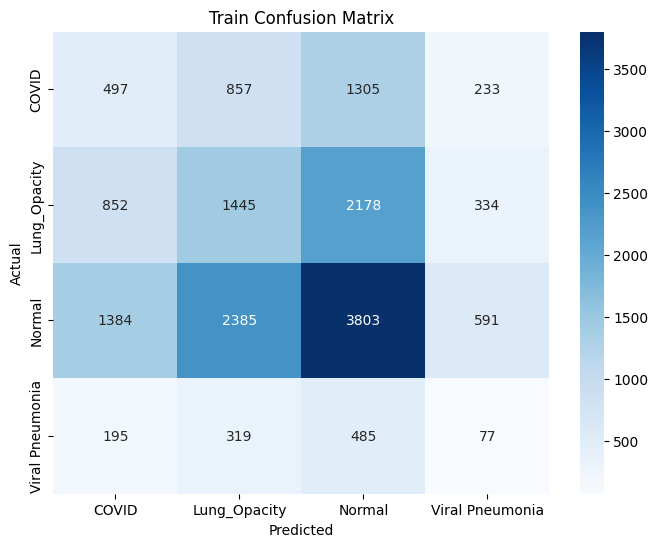

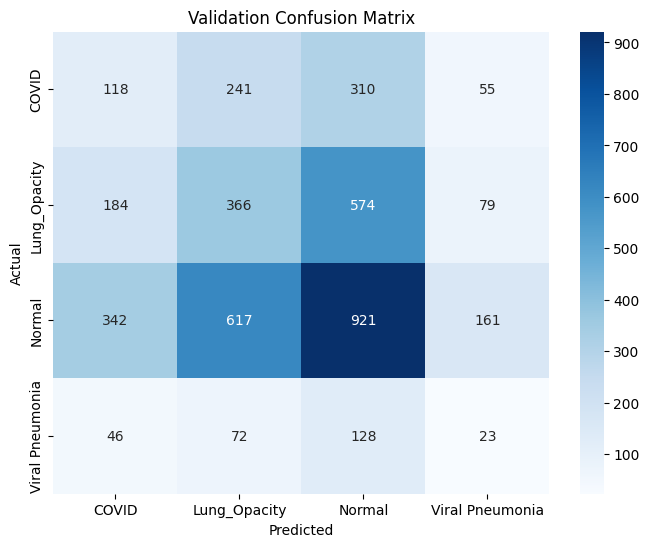

In [13]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(true_train_labels, train_pred_classes, "Train Confusion Matrix")
plot_conf_matrix(true_val_labels, val_pred_classes, "Validation Confusion Matrix")


In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Pick any test image
img_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1.png'  # replace with any

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
pred_idx = np.argmax(pred)

class_names = list(train_data.class_indices.keys())
print("Predicted class:", class_names[pred_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Lung_Opacity


In [15]:
def generate_report(class_name):
    templates = {
        "COVID": "The image shows bilateral ground-glass opacities, consistent with COVID-19 pneumonia.",
        "NORMAL": "No significant abnormalities detected in the lungs.",
        "Lung_Opacity": "Lung opacities suggest fluid buildup or possible infection. Recommend further testing.",
        "Viral Pneumonia": "Findings are consistent with viral pneumonia. Further clinical evaluation advised."
    }
    return templates.get(class_name, "Report not available.")

report_text = generate_report(class_names[pred_idx])
print("Diagnosis Report:", report_text)


Diagnosis Report: Lung opacities suggest fluid buildup or possible infection. Recommend further testing.


In [16]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.1 MB/s eta 0:00:00


In [17]:
from reportlab.pdfgen import canvas


In [18]:
from reportlab.pdfgen import canvas

def save_pdf(image_path, diagnosis, report_text):
    pdf_file = "xray_report.pdf"
    c = canvas.Canvas(pdf_file)
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, 800, "Chest X-ray Diagnostic Report")
    c.setFont("Helvetica", 12)
    c.drawString(50, 770, f"Prediction: {diagnosis}")
    c.drawString(50, 740, f"Report: {report_text}")
    c.drawImage(image_path, 50, 500, width=200, height=200)
    c.save()
    print("✅ PDF report saved.")

save_pdf(img_path, class_names[pred_idx], report_text)


✅ PDF report saved.


In [19]:
from google.colab import files
files.download("xray_report.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Save the entire model to a single HDF5 file.
model.save('covid_classification_model.h5')